In [1]:
library(reticulate)
library(tidyverse)
library(FactoMineR)
library(plot3D)
library(survival)
library(survminer)
library(mice)
library(VIM)
library(reshape2)
library(ggridges)
library(viridis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
Loading required package: ggpubr

Attaching package: ‘mice’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    cbind, rbind

Loading required package: colorspace
Loading required package: grid
VIM is ready to use.

Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues

Attaching package: ‘VIM’

The following object is masked from ‘package:datasets’:

    sleep


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smit

In [2]:
colors = read.csv("../../color.csv", stringsAsFactors = FALSE)
rownames(colors) = colors$type
colors

,type,color
avatar,avatar,#67C6A7
original,original,#f5f5f5
k_small,k_small,#c6eade
k_high,k_high,#407c68
benign,benign,#6786c6
malignant,malignant,#e19252
wbcd,wbcd,#a767c6
aids,aids,#c6a767


In [3]:
# import specific function to compute metrics 
py_run_string("import sys")
py_run_string("sys.path.append('../../metrics')")
py_run_string("sys.path.append('../../dimension')")

py_run_string("from security_metrics_class import Security_metrics ")
py_run_string("from projection import Projection")
py_run_string("from record_to_avatar_distance import record_to_avatar_distance")
py_run_string("from local_cloaking import local_cloaking")
py_run_string("from avatars_are_first_hit import avatars_are_first_hit")
py_run_string("from hidden_rate import hidden_rate")



In [4]:
save <- FALSE

In [5]:
file_data = "../../datasets/WBCD/"
file_results = "../../figure/"

In [6]:
data <- read.csv(paste0(file_data, "breast_cancer_wisconsin.csv"), sep = ",", na.strings = c("NA", "", NA))
data <- data[,-1]

seq_k = c(4,50,100,150, 200,300)

summary(as.factor(data$Class))

2   4 
444 239

# Projection 

In [63]:
# Small k
k = 4 ; iter = 5
avatar_tot <- read.table(unz(paste0(file_data, "wbcd_avatarized.zip"), 
                             paste0("wbcd_avatarized/k", k, "_wbcd_avatarized.csv")), sep = ",", header = TRUE)
avatar_small<- avatar_tot[avatar_tot$iter_k == iter,]


In [64]:
# high k
k = 342 ; 
avatar_tot <- read.table(unz(paste0(file_data, "wbcd_avatarized.zip"), 
                             paste0("wbcd_avatarized/k", k, "_wbcd_avatarized.csv")), sep = ",", header = TRUE)
avatar_high <- avatar_tot[avatar_tot$iter_k == iter,]


In [65]:
data_small_high <- rbind(data[,1:10], avatar_small[,1:10], avatar_high[,1:10])

row.names(data_small_high) <- 1:nrow(data_small_high)
dim(data_small_high)

[1] 2049   10

In [66]:
pca <- PCA(data_small_high, ncp = 5, graph = FALSE, ind.sup = (nrow(data_small_high)/3 +1):nrow(data_small_high))
res_ind <- as.data.frame(pca$ind.sup$coord)[1:683,]
res_ind_sup <- as.data.frame(pca$ind.sup$coord)[684:1366,]

dim(res_ind)

[1] 683   5

## 2D projection

In [67]:
res_ind_2D = res_ind[,1:2]
res_ind_2D['type'] = 'k = 4'
res_ind_sup['type'] = 'k = 342'
res_ind_2D = rbind(res_ind_2D, res_ind_sup[, c('Dim.1', 'Dim.2', 'type')])

set.seed(42)
rows <- sample(nrow(res_ind_2D))
res_ind_2D <- res_ind_2D[rows, ]


In [69]:
save = TRUE

options(repr.plot.width = 8, repr.plot.height = 5)
if (save) {tiff(paste0(file_results, "WBCD_pca2D_Ksmall_high.tiff"), res = 600, width = 14, height = 8, units = "cm")}


ggplot(res_ind_2D, aes(x=Dim.1, y=Dim.2, fill=type)) +
    geom_point(size=2, shape=21, alpha=0.9) +
    aes(fill = factor(type)) + 
    scale_fill_manual(values=c( 'k = 4' = colors["k_small", "color"],'k = 342' =  colors["k_high", "color"])) +
    xlab(paste0("Dim. 1 (", round(pca$eig[1,2], 2) ,"%)")) +
    ylab(paste0("Dim. 2 (", round(pca$eig[2,2], 2) ,"%)")) +
    labs(fill = "") +
    theme_linedraw()+
    theme(legend.position = c(0.9,0.2))


if (save) {dev.off()}

png 
  2

## Local cloaking computation 

In [70]:
df_local_cloaking_k100 <- data.frame(row.names = 1:nrow(data))
hidden_rate_list = c()

pr = py$Projection()
coord_original= pr$fit_transform(data, nf = 2L)[[1]]


In [71]:
for (k in seq_k) {
    iter = 1
    avatar_tot <- read.table(unz(paste0(file_data, "wbcd_avatarized.zip"), 
                                 paste0("wbcd_avatarized/k", k, "_wbcd_avatarized.csv")), sep = ",", header = TRUE)
    avatar <- avatar_tot[avatar_tot$iter_k == iter,]
    print(dim(avatar[1:10]))
    coord_avatar = pr$transform(avatar[,1:10]) 
    
    # Local cloaking
    distances = py$record_to_avatar_distance(coord_original, coord_avatar)
    local_cloaking <- py$local_cloaking(coord_original, coord_avatar, distances)
    df_local_cloaking_k100[paste0("local_cloaking_", k)] <- local_cloaking$hit_counts[,1]
    
    # Hidden rate
    are_first_hit = py$avatars_are_first_hit (coord_original, coord_avatar, distance_metric='euclidean')
    hidden_rate = py$hidden_rate(are_first_hit)
    hidden_rate_list = c(hidden_rate_list, hidden_rate)
}

[1] 683  10
[1] 683  10
[1] 683  10
[1] 683  10
[1] 683  10
[1] 683  10


In [73]:
df_local_cloaking_k100["Class"] = data$Class
head(df_local_cloaking_k100)

local_cloaking_4,local_cloaking_50,local_cloaking_100,local_cloaking_150,local_cloaking_200,local_cloaking_300,Class
9,9,9,17,118,13,2
11,19,10,4,30,167,2
81,115,159,85,370,93,2
32,48,98,50,604,188,2
2,2,2,88,2,187,2
9,121,247,54,235,34,4


In [74]:

df_melt <- melt(df_local_cloaking_k100, id.vars = 'Class' )

hidden_rate_list = rep(hidden_rate_list, each = 683)
df_melt['hidden_rate'] = hidden_rate_list

In [75]:
save = FALSE

Picking joint bandwidth of 19.1
Picking joint bandwidth of 19.1
Warning message:
“Removed 4 rows containing non-finite values (stat_density_ridges).”

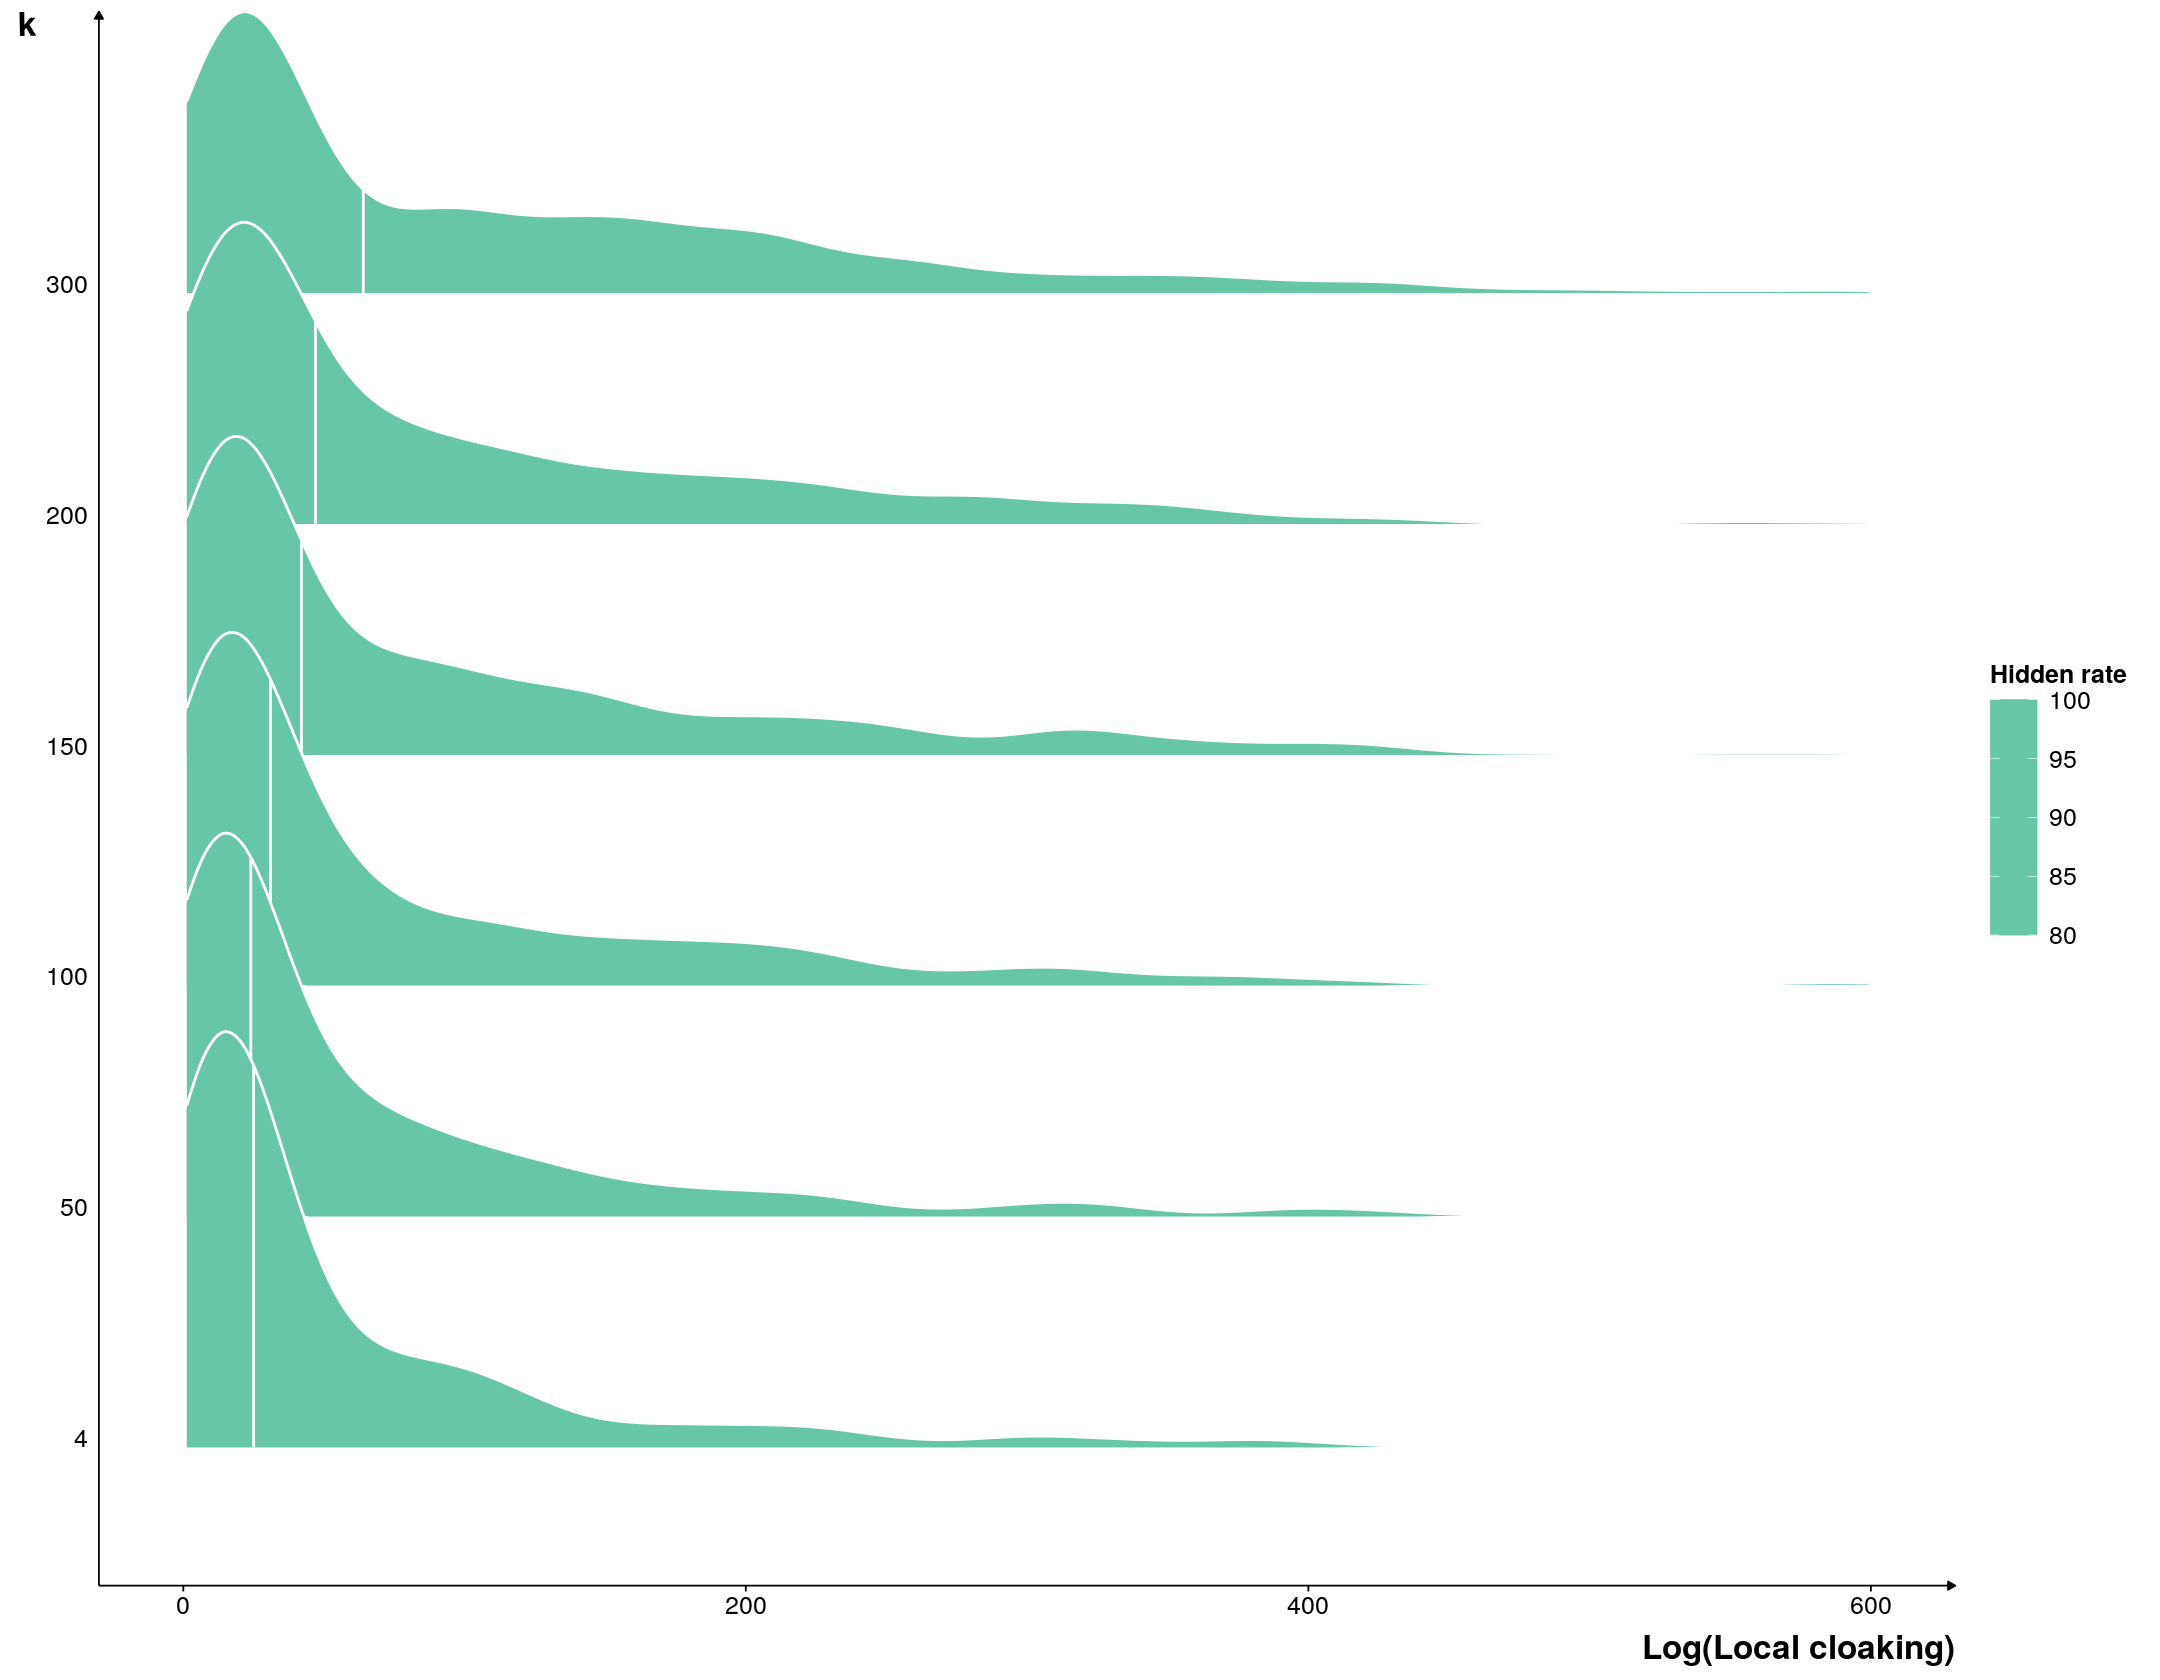

In [76]:
options(repr.plot.width = 18, repr.plot.height = 14)

if (save) {tiff(paste0(file_results, "WBCD_localCloaking_variousk.tiff"), res = 600, width = 18, height = 14, units = "cm")}

ggplot(data = df_melt, aes(x = value, y = variable, fill = hidden_rate))+ 
    # density ridges
    geom_density_ridges_gradient(color = "white", size = 2) +

    # color according hidden rate (here we put the ame color)
    scale_fill_gradient(low = colors["avatar", "color"], high =colors["avatar", "color"], limits= c(80,100)) +
    theme_ridges(grid = FALSE) + 
    # add median in white
    stat_density_ridges(quantile_lines = TRUE, quantiles = 2, color = "white", size = 0.8) +
    # add labs, axis, etc
    xlab("Log(Local cloaking)") +
    ylab("k") +
    labs(fill="Hidden rate") + 
    xlim(c(0, 600)) +
   # scale_x_continuous(
   #     breaks = c(0, 100, 200, 300, 400), limits = c(0, 400),
   #     expand = c(0, 0), name = "Local Cloaking") +
    scale_y_discrete(labels = as.character(seq_k)) +
    theme(axis.title.y = element_text(angle = 1, vjust = 1, size = 20, face = "bold"),
          axis.text=element_text(size=15), 
          axis.title.x = element_text(size = 20, face = "bold"),
          legend.title = element_text(color = "black",face = "bold", size = 15),
          legend.text = element_text(size = 15),
          legend.key.size = unit(1, 'cm'),
          axis.line = element_line(colour = "black", 
                      size = 0.5, linetype = "solid", arrow = arrow(type='closed', length = unit(5,'pt'))))+ 
    scale_color_gradient2(midpoint = mid, low = "blue", mid = "white",
                            high = "red")  

if (save) {dev.off()}

# Violin plot

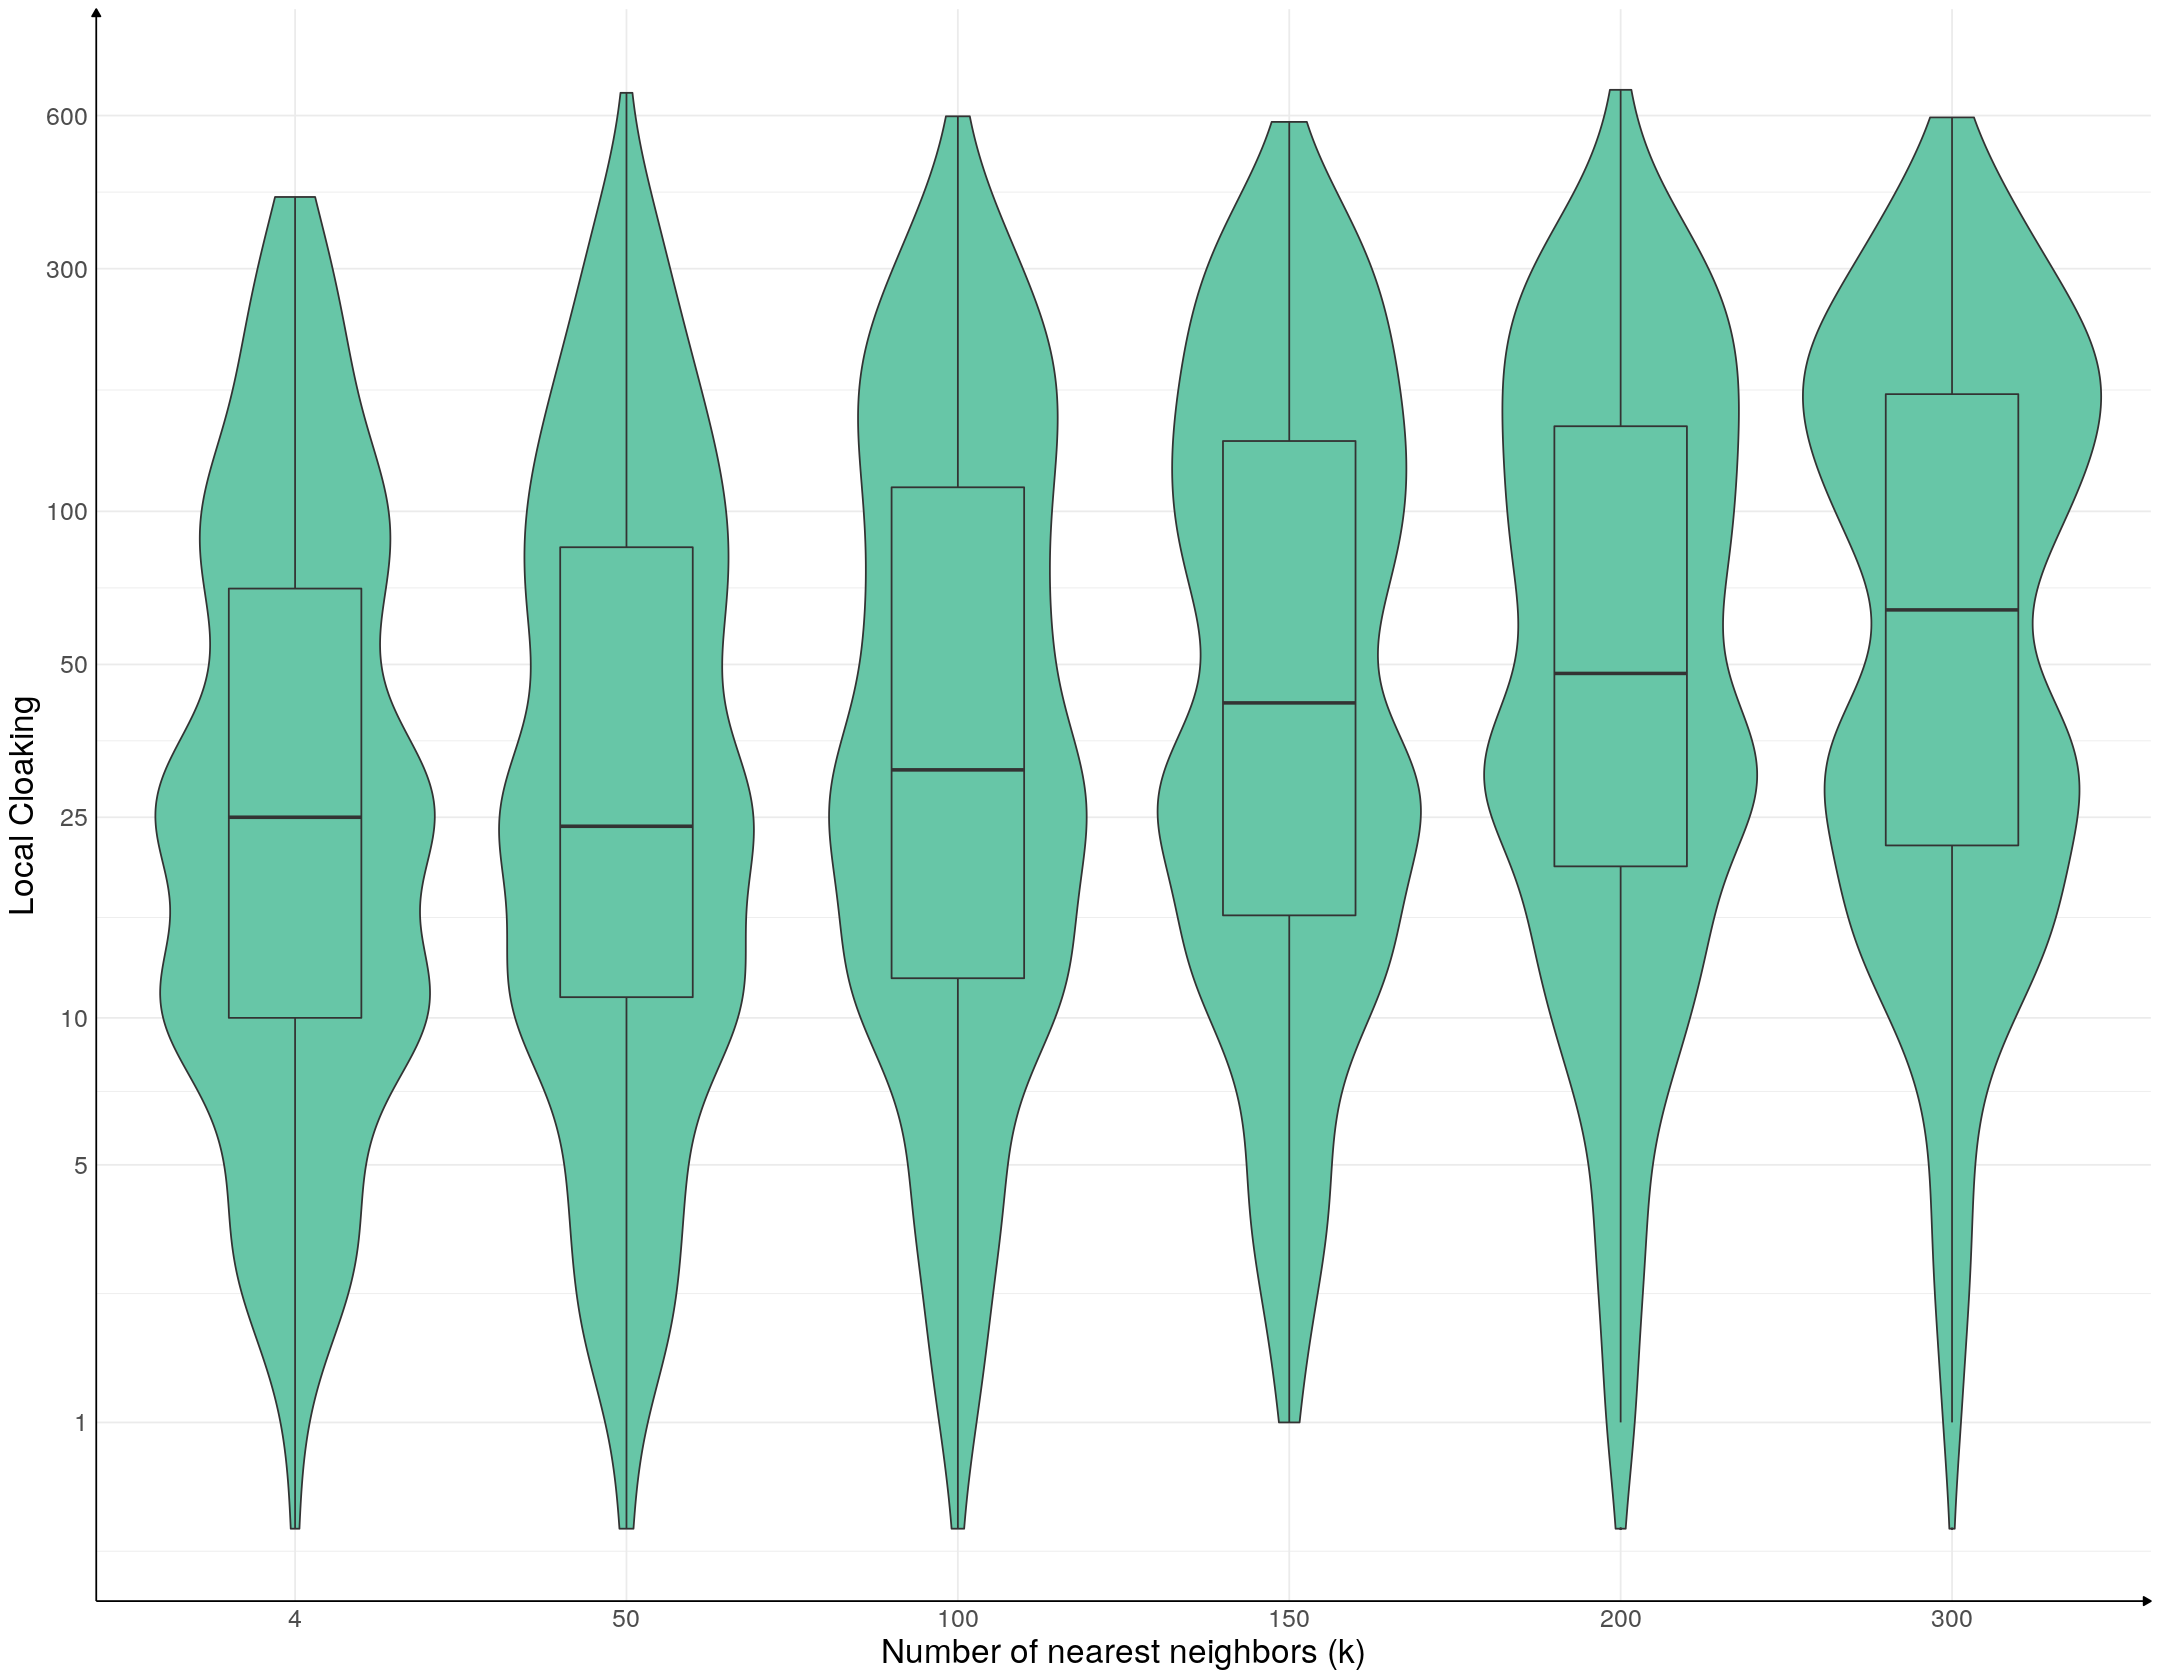

In [78]:
save = FALSE
if (save) {tiff(paste0(file_results, "WBCD_localCloaking_violinplot.tiff"), res = 600, width = 25, height = 14, units = "cm")}



ggplot(df_melt, aes(x = variable, fill = factor(Class), y =value)) + 
    geom_violin(trim=TRUE, fill = colors['avatar', 'color'])+
    geom_boxplot(width=0.4, fill = colors['avatar', 'color'], outlier.size = 0.1) +
    scale_x_discrete(labels = as.character(seq_k)) +
    scale_y_continuous(trans=scales::pseudo_log_trans(base = 10), breaks = c(1,5,10,25,50,100,300, 600)) +
    xlab("Number of nearest neighbors (k)") +
    ylab("Local Cloaking") +
    theme_minimal() +  
    theme(legend.position = "right",
          axis.title.y = element_text(angle = 90, vjust = 1, size = 20),
          axis.text=element_text(size=15), 
          axis.title.x = element_text(size = 20),
          axis.line = element_line(colour = "black", 
                      size = 0.5, linetype = "solid", arrow = arrow(type='closed', length = unit(5,'pt'))))+ 
    coord_cartesian(ylim = c(0, 700))

if (save) {dev.off()}

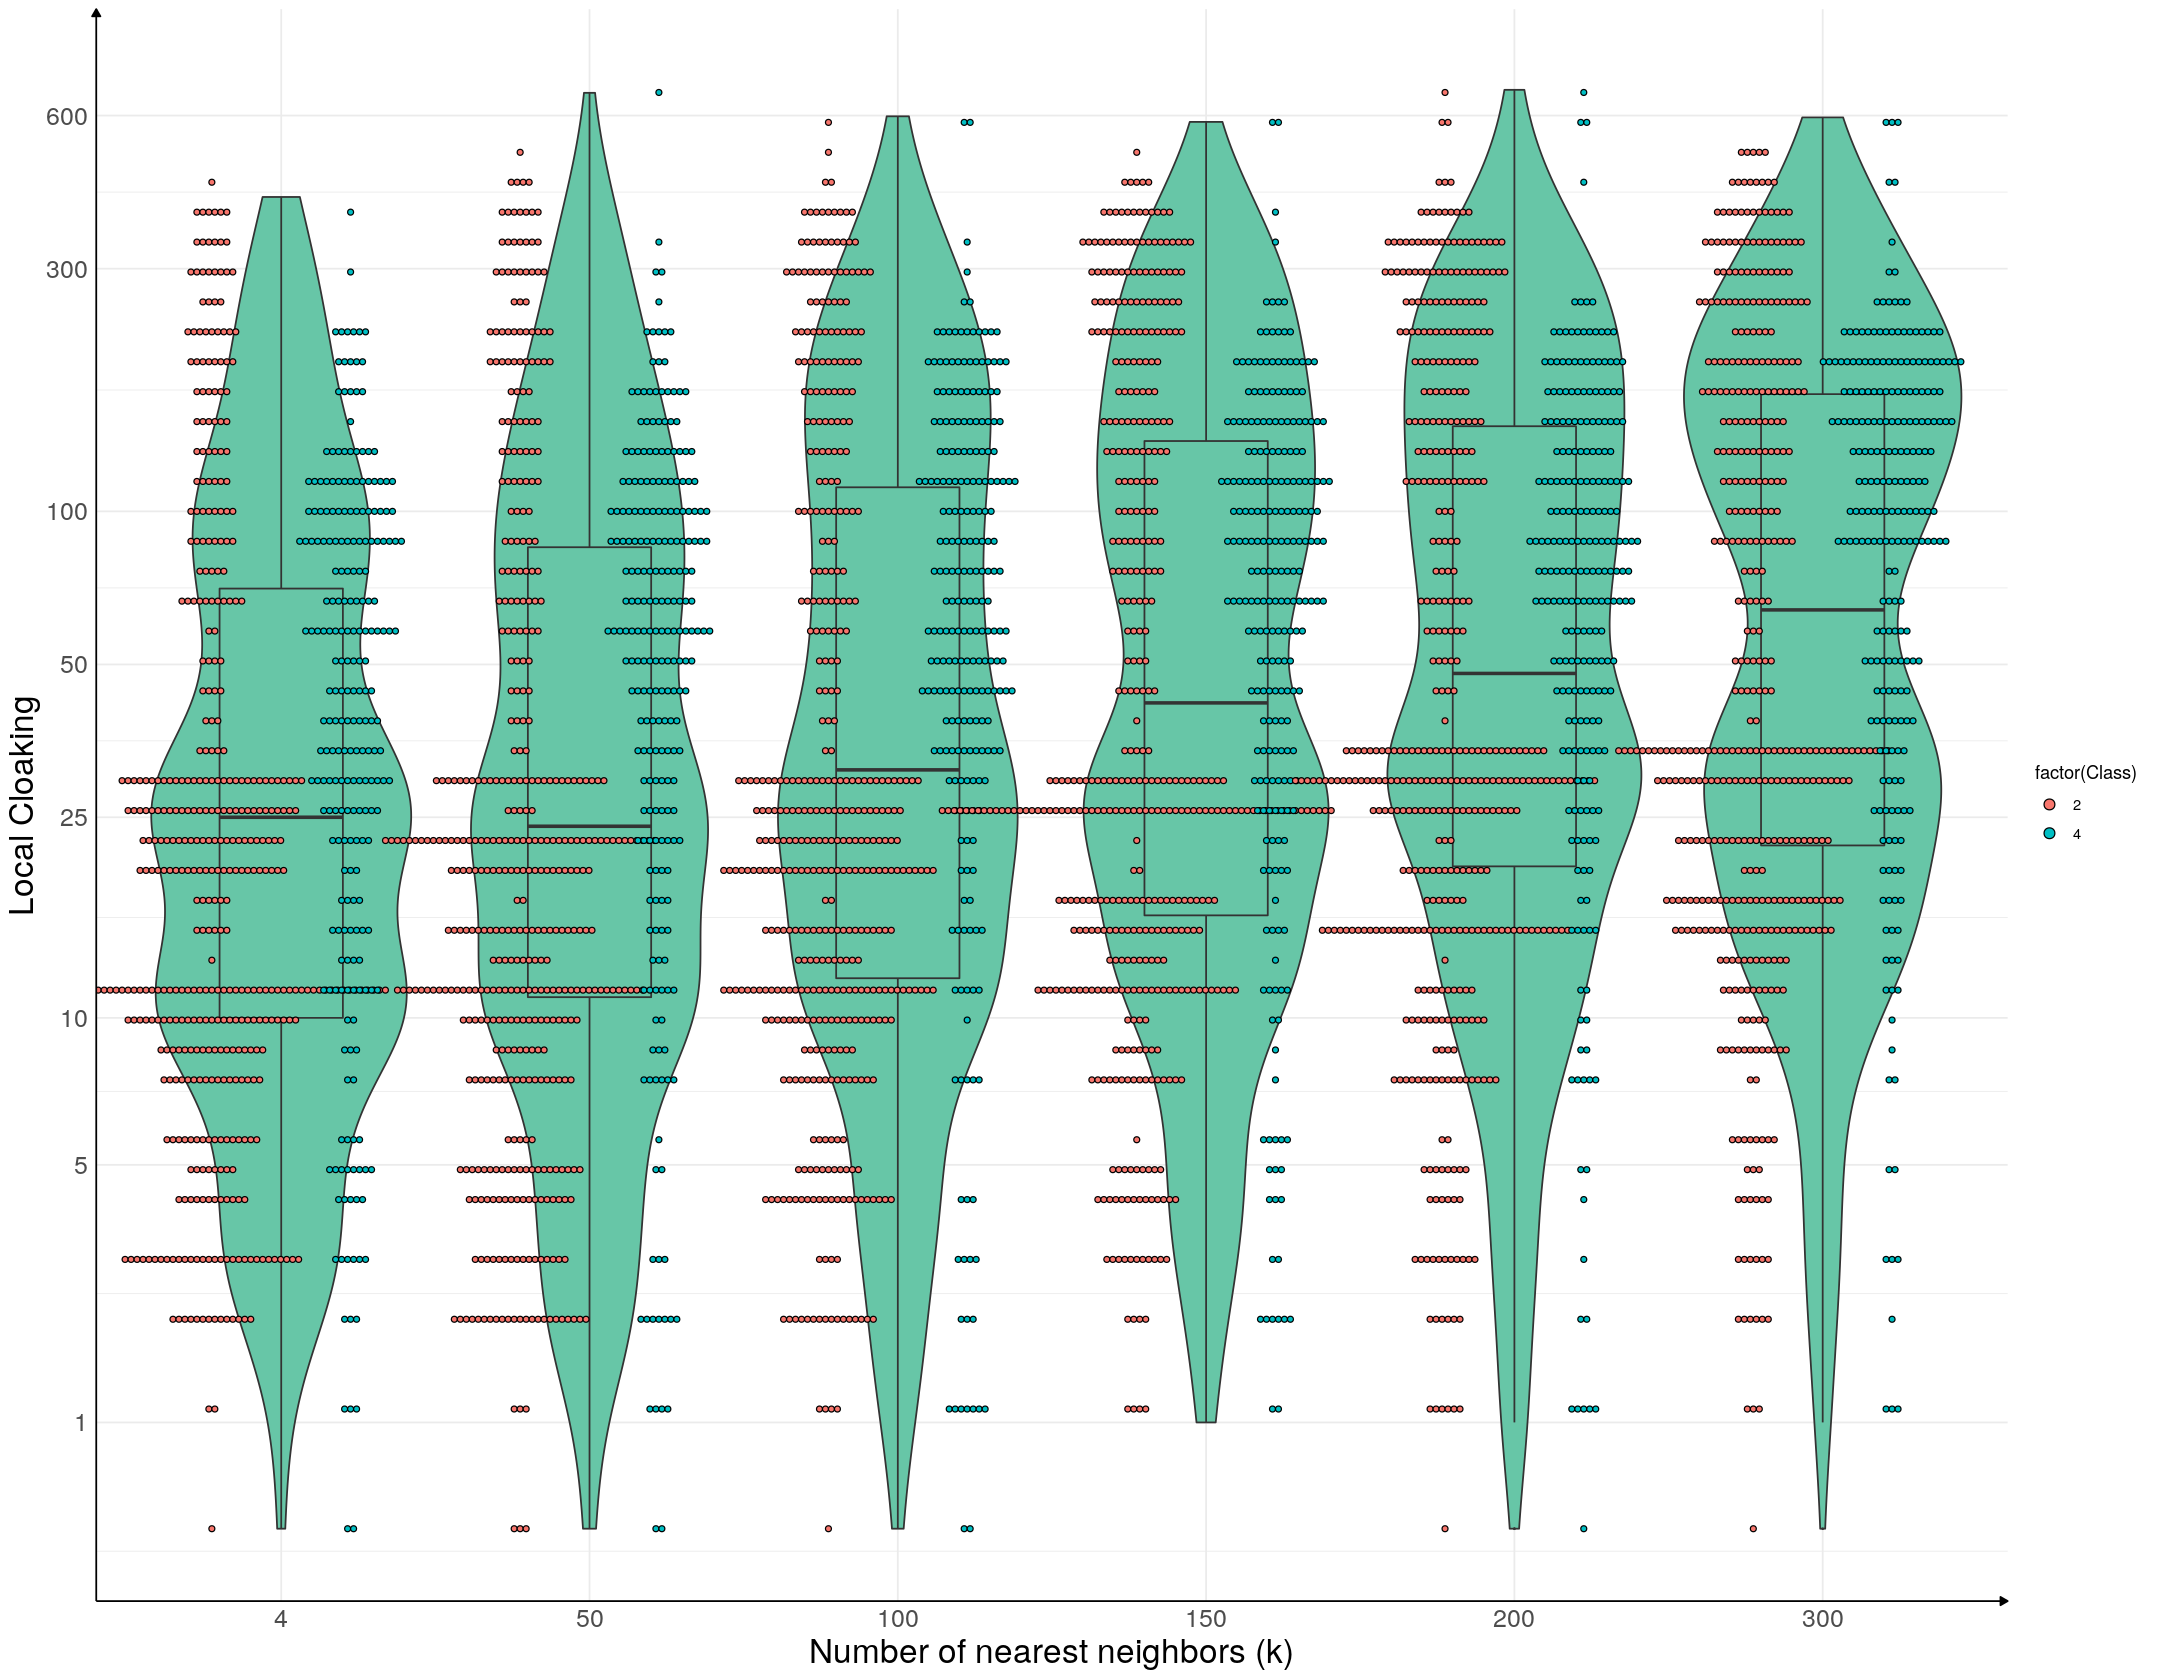

In [77]:
save = FALSE
if (save) {tiff(paste0(file_results, "WBCD_localCloaking_violinplot.tiff"), res = 600, width = 25, height = 14, units = "cm")}



ggplot(df_melt, aes(x = variable, fill = factor(Class), y =value)) + 
    geom_violin(trim=TRUE, fill = colors['avatar', 'color'])+
    geom_boxplot(width=0.4, fill = colors['avatar', 'color'], outlier.size = 0.1) +
    scale_x_discrete(labels = as.character(seq_k)) +
    scale_y_continuous(trans=scales::pseudo_log_trans(base = 10), breaks = c(1,5,10,25,50,100,300, 600)) +
    geom_dotplot(binaxis= "y",
                 stackdir = "center", position = "dodge",
                 dotsize = 0.2, 
                 method = 'histodot',
                 binwidth = 1/17
                 
                )+
    xlab("Number of nearest neighbors (k)") +
    ylab("Local Cloaking") +
    theme_minimal() +  
    theme(legend.position = "right",
          axis.title.y = element_text(angle = 90, vjust = 1, size = 20),
          axis.text=element_text(size=15), 
          axis.title.x = element_text(size = 20),
          axis.line = element_line(colour = "black", 
                      size = 0.5, linetype = "solid", arrow = arrow(type='closed', length = unit(5,'pt'))))+ 
    coord_cartesian(ylim = c(0, 700))

if (save) {dev.off()}